In [2]:
from astropy.io import fits
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

In [3]:
import healpy as hp
prob, distmu, distsigma, distnorm = hp.read_map('bayestar.fits', field = [0,1,2,3])
hpy = hp.read_map('bayestar.fits.gz')

NSIDE = 512
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING
Ordering converted to RING
Ordering converted to RING
Ordering converted to RING
NSIDE = 256
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING


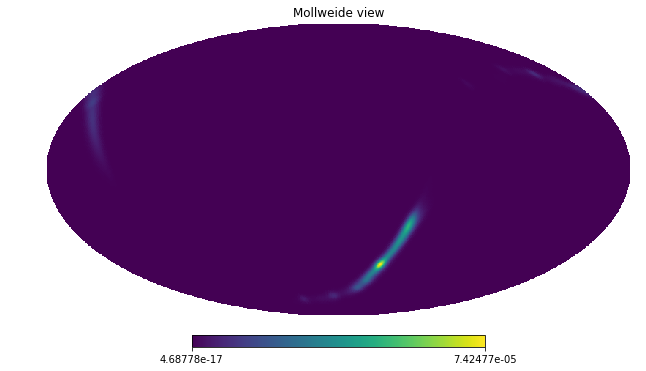

In [4]:
hp.mollview(prob, rot=180)

In [58]:
prob1 = list(prob)
npix = len(prob)
nside = hp.npix2nside(npix)

In [59]:
ipix = prob1.index(np.amax(prob1))
theta, phi = hp.pix2ang(nside, ipix)
ra = np.rad2deg(phi)
dec = np.rad2deg(0.5 * np.pi - theta)
ra, dec

(146.19767441860463, -49.896983831974104)

In [60]:
r = np.linspace(0,7000,num=1000)

In [61]:
def distance(rr, pixel):
    return distnorm[pixel]/(np.sqrt(2*np.pi)*distsigma[pixel])*np.exp(-(rr-distmu[pixel])**2 
                                                               /(2*distsigma[pixel])**2)*rr**2

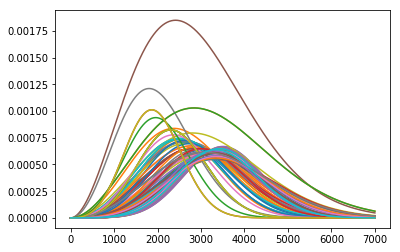

In [73]:
for pix in range(200):
    pix1 = pix*1000
    most_probable_distance = max(distance(r,pix1))
    plt.plot(r, distance(r, pix1))

In [69]:
dist = distance(r,5)
dist = list(dist)
inde = dist.index(np.amax(dist))
most_probable distance = inde * 7 #in units of Mpc

3409

In [70]:
len(prob1)

3145728